In [18]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
# Add src directory to path so we can import tailrisk
src_path = str(Path.cwd().parent / "src")
sys.path.insert(0, src_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from scipy import stats

from tailrisk import (
    compute_log_returns,
    historical_var, historical_es,
    parametric_var_normal, parametric_es_normal,
    parametric_var_t, parametric_es_t,
    fit_gpd_mle, gpd_var_es,
    kupiec_test, christoffersen_test,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
ticker = "TSLA"
start = "2010-01-01"
end   = None  # None = up to today

data = yf.download(ticker, start=start, end=end,auto_adjust=False)
data.head()


[*********************100%***********************]  1 of 1 completed



Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


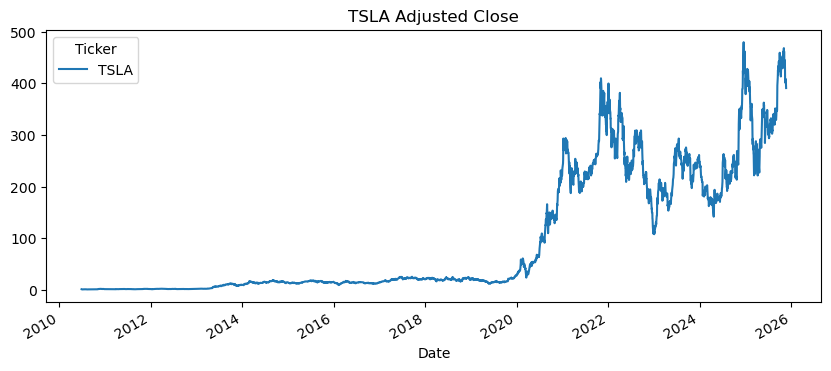

In [20]:
prices = data["Adj Close"].dropna()
prices.name = "TSLA_adj_close"
prices.plot(figsize=(10, 4), title="TSLA Adjusted Close")
plt.show()


C:\Users\xingl\AppData\Local\Temp\ipykernel_25468\2982265140.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  daily_vol = float(rets.std())


Ticker         TSLA
count   3875.000000
mean       0.142027
std        3.630277
min      -23.651789
25%       -1.667601
50%        0.121985
75%        1.943541
max       21.829241

Daily volatility: 3.63%
Annual volatility: 57.63%


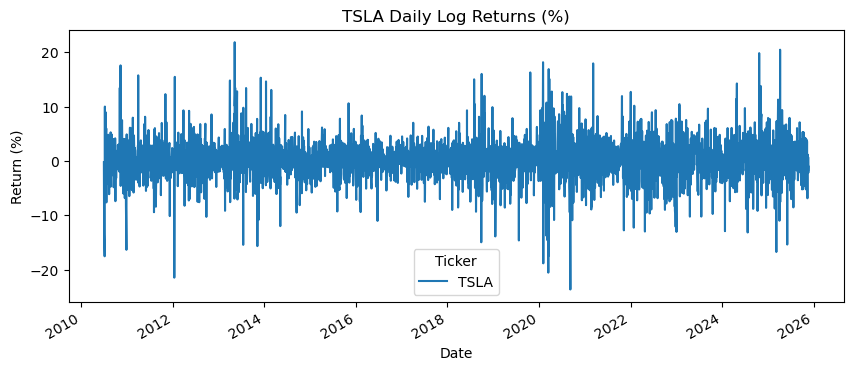

In [21]:
# Compute returns and convert to percentage (standard in quant finance)
rets = compute_log_returns(prices) * 100
print(rets.describe())

daily_vol = float(rets.std())
annual_vol = daily_vol * np.sqrt(252)
print(f"\nDaily volatility: {daily_vol:.2f}%")
print(f"Annual volatility: {annual_vol:.2f}%")

rets.plot(figsize=(10, 4), title="TSLA Daily Log Returns (%)")
plt.ylabel("Return (%)")
plt.show()

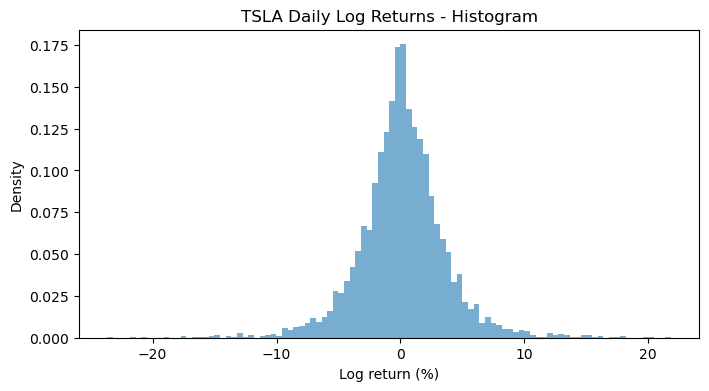

In [22]:
plt.figure(figsize=(8, 4))
plt.hist(rets, bins=100, density=True, alpha=0.6)
plt.title("TSLA Daily Log Returns - Histogram")
plt.xlabel("Log return (%)")
plt.ylabel("Density")
plt.show()


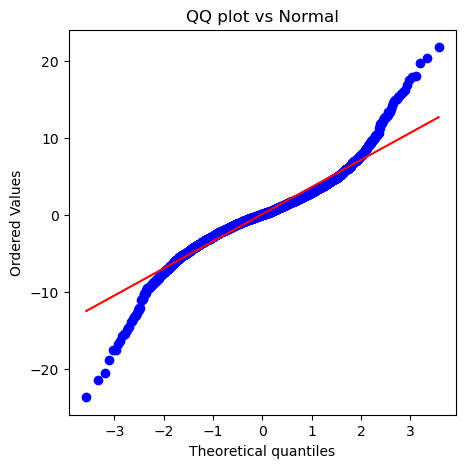

In [23]:
plt.figure(figsize=(5, 5))
stats.probplot(np.asarray(rets).flatten(), dist="norm", plot=plt)
plt.title("QQ plot vs Normal")
plt.show()


### Conclusion on Daily Returns Distribution

The **QQ plot vs Normal** distribution clearly shows that the daily returns of **TSLA** exhibit significant deviation from a standard Normal distribution, particularly in the extreme ranges.

1.  **Fat Tails:** The blue points at both the positive (right) and negative (left) extremes of the plot sharply diverge from the red reference line. This indicates the presence of **fat tails**, meaning that extreme market movements (large gains or large losses) occur **more frequently and with greater magnitude** than predicted by the Normal distribution.
2.  **Skewness:** The overall curvature and slightly asymmetric deviation of the points suggest the distribution is also **skewed**.

This empirical evidence—the clear presence of **fat tails and non-normality**—provides the strong motivation for employing specialized methods, such as **Extreme Value Theory (EVT) tail modeling**, to accurately capture and quantify the true tail risk (e.g., Value at Risk, or VaR) associated with TSLA stock.

In [25]:

# Save the data to CSV for reuse in other notebooks
data_path = Path.cwd().parent / "data"
data_path.mkdir(exist_ok=True)

# Save raw data
data.to_csv(data_path / "TSLA_raw.csv")

# Save prices and returns (already in %)
prices.to_csv(data_path / "TSLA_prices.csv")
rets.to_csv(data_path / "TSLA_returns.csv")

print(f"Data saved to {data_path}")
print(f"  - TSLA_raw.csv: {len(data)} rows")
print(f"  - TSLA_prices.csv: {len(prices)} rows")
print(f"  - TSLA_returns.csv (in %): {len(rets)} rows")


Data saved to c:\playpen\GitHub Projects\tail-risk-var-es-evt\data
  - TSLA_raw.csv: 3876 rows
  - TSLA_prices.csv: 3876 rows
  - TSLA_returns.csv (in %): 3875 rows
